In [28]:
from tesspy import Tessellation, tessellation_functions
import geopandas as gpd
import pandas as pd

In [17]:
gdf_all = gpd.read_file("files/all_deps.shp")
gdf_all.crs = {"init": "epsg:4326"}

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,"POLYGON ((0.83676 48.00880, 0.83650 48.00960, ..."


In [19]:
deps = Tessellation(gdf)

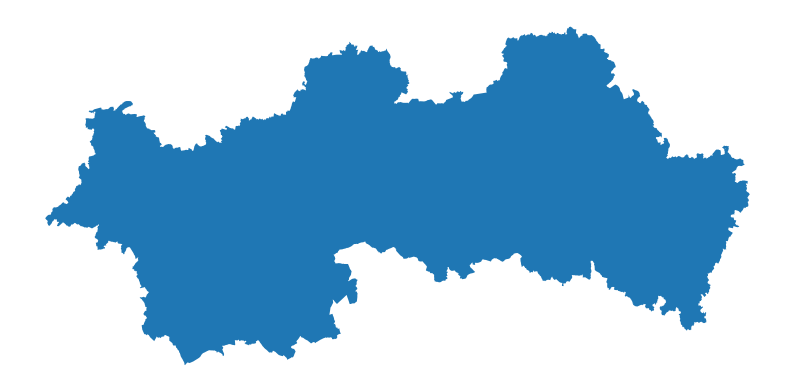

In [21]:
deps.get_polygon().plot(figsize=(10, 10)).set_axis_off()

In [23]:
print(deps.get_polygon().crs)

EPSG:4326


In [31]:
deps_sqr_13 = tessellation_functions.get_squares_polyfill(deps.area_gdf, 13)

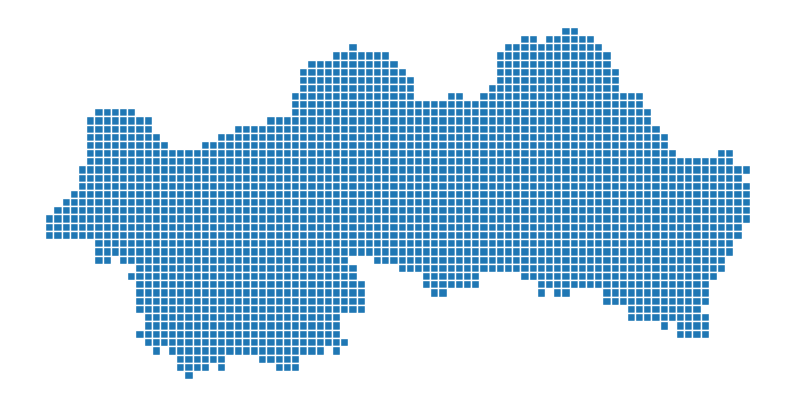

In [32]:
deps_sqr_13.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off()

In [ ]:
# self.area_gdf
# self.poi_dataframe

def adaptive_squares(
    self,
    start_resolution: int,
    poi_categories=["amenity", "building"],
    threshold=None,
    timeout=60,
    verbose=False,
):
    points_geom = tess_data[["center_longitude", "center_latitude"]].apply(
        lambda p: Point(p["center_longitude"], p["center_latitude"]), axis=1
    )
    tess_data = gpd.GeoDataFrame(
        geometry=points_geom, data=tess_data[poi_categories], crs="EPSG:4326"
    )
    poi_data_aqk = tess_data.rename(columns={"points_geom": "geometry"})
    df_aqk = get_squares_polyfill(self.area_gdf, start_resolution)
    aqk_count_df = count_poi(df_aqk, poi_data_aqk)

    if not threshold:
        threshold = int(np.median(aqk_count_df["count"].values))
        if verbose:
            print(
                f"Threshold={threshold}  ==> set as the median POI-count per square at the initial level"
            )

    i = start_resolution
    while max(aqk_count_df["count"].values) > threshold:
        i += 1
        if verbose:
            print(f"Threshold exceeded! Squares are subdivided into resolution {i}")

        df_tmp = get_adaptive_squares(aqk_count_df, threshold)
        df_tmp.drop(columns=["count"], inplace=True)
        df_tmp2 = count_poi(df_tmp, poi_data_aqk)
        aqk_count_df = df_tmp2

    final_aqk = gpd.sjoin(aqk_count_df, self.area_gdf)
    final_aqk = final_aqk.drop(columns=["osm_id", "children_id", "index_right"])

    return final_aqk